# Historical Indiana Groundwater Chemistry within the Wabash Basin by HUC 12 boundary

This notebook looks at a historical groundwater chemistry dataset of six groundwater basins in Indiana, published by the Indiana DNR, and completes an interpolation analysis of groundwater hardness in the dataset. 

### Overview

A significant portion of Indiana overlaps the Wabash Basin, a sub-watershed of the Missippi River Basin. With an understanding of how rainfall and groundwater recharge impact groundwater chemistry, groundwater chemistry could be predicted based on how groundwater chemistry responds to water input in the system (in the form of recharge).

This interpolation analysis is a step towards forecasting groundwater chemistry. Forecasting was not completed in this analysis, but could be done by combining historical groundwater chemistry with historial groundwater recharge data and extrapolating the correlation to the predicted models of several RCP emission scenarios. 

### The Historical Groundwater Dataset

This notebook looks at a historical groundwater chemistry dataset published by the Indiana DNR. The dataset contains several groundwater chemistry parameters. The intent of the analysis is 

The datset was downloaded from https://www.in.gov/dnr/water/publications/ambient-ground-water-chemistry/ and can be found in the folder ```research_project\IDNR_GWchem```. 

> Citation: IDNR-DOW Catalog #108, Basin Studies Section, Division of Water, Indiana Department of Natural Resources.

We'll start with importing the necessary libraries and IDNR datafile.

In [229]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import utm
import shapefile
import geopandas as gpd
import numpy as np
from scipy.interpolate import NearestNDInterpolator 

In [230]:
#import data

#set the filepath
gw_filepath = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\IDNR_GWchem\Data\GWCHEM_AA.xls"

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
IDNR_gw_full = pd.read_excel(gw_filepath, 
                             sheet_name = "basins", 
                             header = 6, 
                             skiprows = 6,
                             #index_col='date', 
                             parse_dates={'date': [32,30,31]})

# show the top of the dataset
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,LEAD,ARS,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,NaN,NaN,B,85,NaN,WF-024,WF
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,NaN,NaN,U,1302,NaN,WF-002,WF
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,NaN,NaN,U,1551,NaN,WF-003,WF
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,NaN,NaN,B,2577,NaN,WF-014,WF
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF


Several of the geochemical parameters measured are listed in the columns on the middle right (Lead, Arsenic, etc.) This analysis later uses the column for Hardness, as this parameter indicates the overall concentration of metals in a water, and will be an okay proxy for the degree the water has interacted with the rock it flows through. 

I used the UTM module to convert the coordinates provided in the dataset to latitude/longitude as shown below. 

In [231]:
#convert UTM coordinates to lat lon
IDNR_gw_full['lat'], IDNR_gw_full['lon'] = utm.to_latlon(IDNR_gw_full['UTME'], IDNR_gw_full['UTMN'], 16, northern=True)
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,B,85,NaN,WF-024,WF,40.207272,-85.547048
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,U,1302,NaN,WF-002,WF,40.195345,-85.445177
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,U,1551,NaN,WF-003,WF,40.170698,-85.380950
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,B,2577,NaN,WF-014,WF,40.250068,-85.497927
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF,40.276208,-85.331388


The best way we can use this data is to convert it into a geodataframe. This is done below.

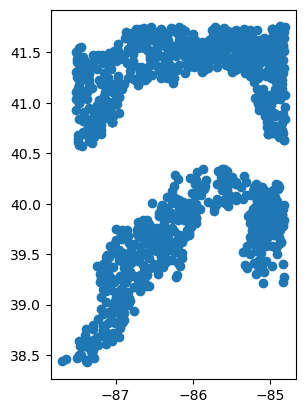

In [232]:
# convert pandas df into geodf
idnr_gdf = gpd.GeoDataFrame(IDNR_gw_full, 
                           geometry= gpd.points_from_xy(IDNR_gw_full['lon'], IDNR_gw_full['lat']),
                            #could also use gpd.points_from_xy(usgs_pd.longitude, ...
                           crs = "EPSG:4326") #shorthand for lat lon

# show bare geodataframe
idnr_gdf.head()
idnr_gdf.plot();


Suspicious pattern. I also want to get a sense of the spread of the data over time when it was sampled. 

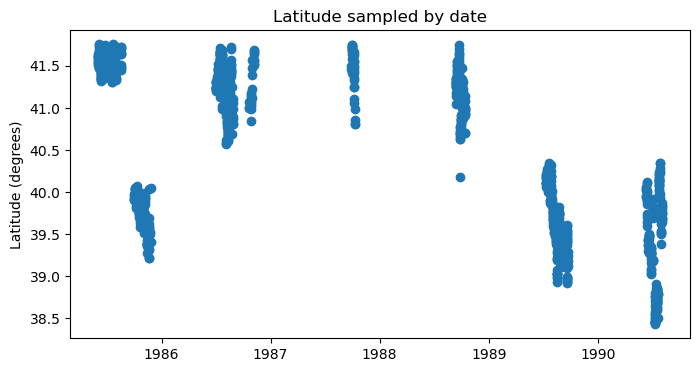

In [233]:

""" display data entries over time """

# create figure
fig, ax = plt.subplots(figsize=(8,4))

# plot dates by latitude
ax.scatter(IDNR_gw_full['date'], IDNR_gw_full['lat'])

# set labels and show
ax.set_title("Latitude sampled by date")
ax.set_ylabel("Latitude (degrees)")
plt.show()

Interesting spread of data over time... There's a suspicious lack of data in the middle latitudes. Let's see what the data looks like on a map.

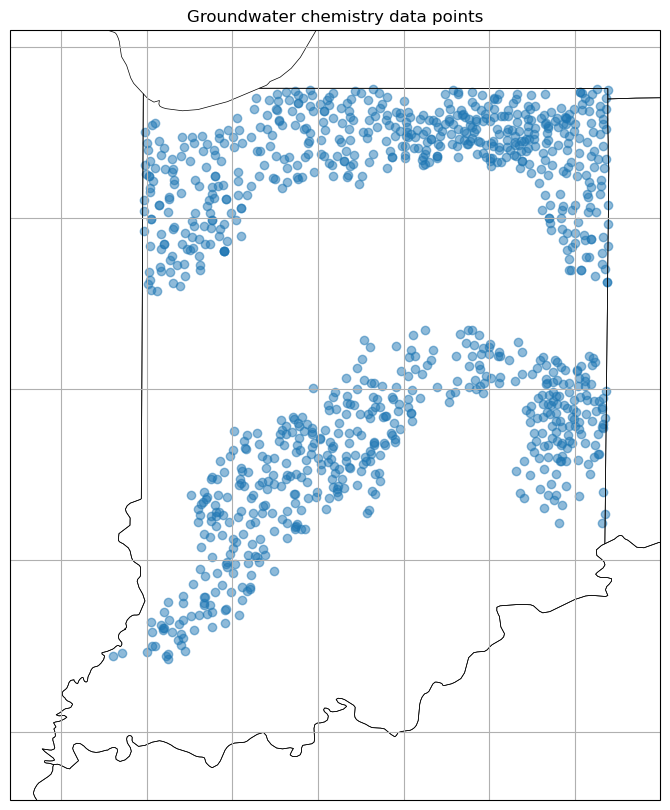

In [234]:
"""Plot data points on the map"""

# Set the projection
projection = cartopy.crs.PlateCarree()

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) # or =dict(projection = projection) ?

# convert projection into PORJ4 string
ax_proj = ax.projection.proj4_init

# convert the IDNR data to the projection
idnr_gdf_proj = idnr_gdf.to_crs(ax_proj)
idnr_gdf_proj.plot(ax = ax, 
                   transform = projection,
                   alpha = 0.5 #transparancy
                   ) 

# add gridlines
ax.gridlines()
# add states outline
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)

# want to see whole state
# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())

ax.set_title("Groundwater chemistry data points");

The coverage here is not great, state-wide. But let's see how it aligns with the Wabash Basin.


## Plotting Points on the Wabash HUC12 Subbasins

First, we'll read in the file and plot it to see how it overlaps with our data.

#### *About the shapefile:*

The HUC 12 shapefile contains all level 12 (the smallest hydrological groundwater basin unit typically available) watershed boundaries within the Wabash Basin (one of the main watersheds in Indiana). A key for what basin # coordinates to the subbasin name is provided in the file:
```research_project\data\WBHUC12shp\WabashSubbasins_IDtoHUC.csv```


This shapefile was downloaded from https://figshare.com/articles/dataset/Wabash_River_Basin_USGS_NHD_HUC_12_polygon_shapefile/8398394 

> Citation: Dierauer, J.R. (2019). Wabash River Basin USGS NHD HUC 12 polygon shapefile. figshare. Dataset. https://doi.org/10.6084/m9.figshare.8398394.v7







In [235]:
# provide path of shapefile
shp_path = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\WBHUC12shp\Wabash_HUC12.shp'

# read the shapefile
HUC_shp = shapefile.Reader(shp_path)

#print what shapetype the shapefile is. NOTE: 5 means polygon
print(HUC_shp.shapeType)

#how many features are there?
len(HUC_shp)


5


1276

Our shapefile is set of 1276 polygons. A review of the file "WabashSubbasins_IDtoHUC.csv" (in ```data\WBHUC12shp```) tells us there is indeed 1276 HUC12 subbasins in the basin, so we're likely looking at the right thing.

Let's plot the shapefile on with the groundwater points.

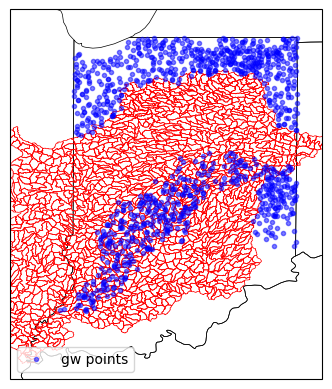

In [236]:
#import more specific functions
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

#create the plot
fig, ax = plt.subplots( subplot_kw= dict(projection = projection))
ax.plot(IDNR_gw_full['lon'], 
        IDNR_gw_full['lat'], 
        '.', color="b", 
        alpha = 0.5,  
        transform = projection, 
        label = "gw points")

# add state boundaries
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)

# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())



# add shapefile as feature
state_feature = ShapelyFeature(Reader(shp_path).geometries(),
                               crs=cartopy.crs.PlateCarree(), facecolor="none", edgecolor='r', linewidth=0.5)
ax.add_feature(state_feature)

# add legend
ax.legend()


# show plot
plt.show() 

From the rough map, it looks like there's enough overlap for us to do an analysis with the overlapping sections.


It's interesting to see the groundwater sample points conform to the outline of the Wabash basin in parts, such as along the north border or part of the east. I wonder what's there that we can't see from this map.

Next, we examine the HUC boundaries shapefile more closely and convert it to a geodataframe:

In [237]:
# convert to geodataframe
HUC_gdf_org = gpd.read_file(shp_path)
HUC_gdf_org.head()

,GRIDCODE,Subbasin,Area_ha,geometry
0,1,1,4318.721679,"POLYGON ((-87.92583 39.88529, -87.92729 39.882..."
1,2,2,6839.489349,"POLYGON ((-87.69378 39.12514, -87.69561 39.121..."
2,3,3,7003.366250,"POLYGON ((-87.58176 38.98668, -87.58353 38.985..."
3,4,4,11780.955140,"POLYGON ((-87.69344 39.06905, -87.69206 39.067..."
4,5,5,6969.422343,"POLYGON ((-88.19354 40.09454, -88.18975 40.092..."


If we can separate points by what subbasin they're in, we can analyze points by subbasin and compare them to the FutureWater data and RCP scenarios.

### Clip points to within the Wabash Basin

Next, I took only the points that fell within the HUC 12 shapefile, therefore restricting the groundwater dataset to points within the Wabash Basin. 

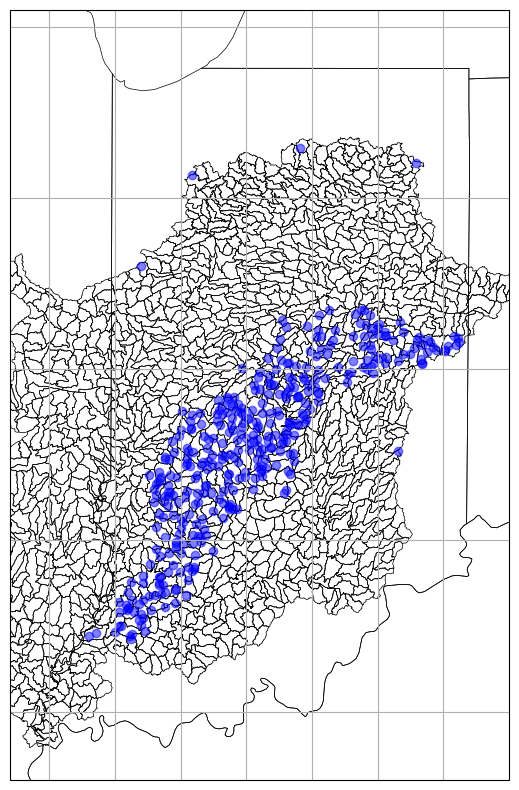

In [238]:
"""clip the IDNR dataset"""

# convert HUC boundary to projection of  dataset
HUC_gdf = HUC_gdf_org.to_crs(idnr_gdf.crs)

# clip the IDNR dataset to the HUC12 boundaries
idnr_gdf_clipped = gpd.clip(idnr_gdf, HUC_gdf) #inputs are (dataset to clip, boundary to clip to)


# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) #does the interior differentiate to cartopy plot, not simple?

# plot HUC 12 boundaries
HUC_gdf.plot(ax=ax, 
             facecolor="none", 
             edgecolor="black",
             linewidth=0.5
             ) #facecolor colors interior of polygon!

# add the IDNR data to the projection
idnr_gdf_clipped.plot(
                    ax = ax, 
                   #transform = projection, #remember to take this out
                   #column = "mag", #if just this, generates points colored by magnitude
                   #markersize = np.exp(name.variable)/10,
                   color="b",
                   alpha = 0.5 #transparancy
                   ) 

# add state boundaries, gridlines
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
ax.gridlines()

# show plot
plt.show()


Let's examine the clipped dataset.

In [239]:
idnr_gdf_clipped

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon,geometry
369,1990-07-10,82044,NaN,WF-280,4253175,467260,63,1,9,14,...,NaN,NaN,B,82044,NaN,WF-280,WF,38.426235,-87.375085,POINT (-87.37509 38.42623)
370,1990-07-10,82045,NaN,WF-279,4254775,466140,63,1S,9,11,...,NaN,NaN,B,82045,NaN,WF-279,WF,38.440612,-87.387993,POINT (-87.38799 38.44061)
366,1990-07-09,82041,NaN,WF-274A,4255100,439185,42,1S,12,12,...,NaN,NaN,B,82041,NaN,WF-274A,WF,38.442111,-87.696875,POINT (-87.69688 38.44211)
368,1990-07-10,82043,NaN,WF-281,4256130,467375,63,1,9,2,...,NaN,NaN,B,82043,NaN,WF-281,WF,38.452870,-87.373905,POINT (-87.37390 38.45287)
367,1990-07-09,82042,NaN,WF-275,4256850,443850,42,1S,11,4,...,NaN,NaN,U,82042,NaN,WF-275,WF,38.458188,-87.643563,POINT (-87.64356 38.45819)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1990-07-24,82196,NaN,WF-334A,4445400,656240,68,20,12,34,...,NaN,NaN,U,82196,NaN,WF-334A,WF,40.144427,-85.165811,POINT (-85.16581 40.14443)
520,1990-07-24,82198,NaN,WF-333,4448210,660355,68,20,13,19,...,NaN,NaN,B,82198,NaN,WF-333,WF,40.168955,-85.116828,POINT (-85.11683 40.16895)
644,1989-07-12,86542,NaN,WF-007,4448070,652890,68,20,12,20,...,NaN,NaN,U,86542,NaN,WF-007,WF,40.169087,-85.204487,POINT (-85.20449 40.16909)
645,1989-07-12,86547,NaN,WF-006,4450575,654370,68,20,12,9,...,NaN,NaN,B,86547,NaN,WF-006,WF,40.191373,-85.186514,POINT (-85.18651 40.19137)


The clip shows us that if we limit the dataset to points within the Wabash basin, it leaves us 379 points to work with. If only there was a way to get rid of the 5 outlier-looking ones. That would strengthen an interpolation map.

### Spatial Join

A spatial join would match all points with polygons. I can't believe I didn't think to do this before. Let's try it.

In [240]:
#spatial join polygons to points
idnr_HUC = gpd.sjoin(idnr_gdf, HUC_gdf) #Join (subject, added feature)
idnr_HUC


,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,Unnamed: 59,Sample #,Basin,lat,lon,geometry,index_right,GRIDCODE,Subbasin,Area_ha
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,WF-024,WF,40.207272,-85.547048,POINT (-85.54705 40.20727),318,319,319,5754.626389
608,1989-07-19,85877,NaN,WF-025,4450050,619030,48,20,8,10,...,NaN,WF-025,WF,40.192404,-85.601639,POINT (-85.60164 40.19240),318,319,319,5754.626389
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,WF-002,WF,40.195345,-85.445177,POINT (-85.44518 40.19534),315,316,316,6738.546593
6,1989-07-10,3082,NaN,WF-001,4453030,632530,18,21,10,31,...,NaN,WF-001,WF,40.217218,-85.442480,POINT (-85.44248 40.21722),315,316,316,6738.546593
516,1990-07-23,82194,NaN,WF-326,4451980,627840,18,20,9,3,...,NaN,WF-326,WF,40.208490,-85.497788,POINT (-85.49779 40.20849),315,316,316,6738.546593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,1990-07-25,142321,NaN,WF-341,4443875,617910,48,20,8,33,...,NaN,WF-341,WF,40.136944,-85.615923,POINT (-85.61592 40.13694),356,357,357,4770.778404
894,1989-07-24,144989,NaN,WF-036,4447400,598700,48,20,6,22,...,NaN,WF-036,WF,40.171172,-85.840830,POINT (-85.84083 40.17117),361,362,362,5843.162150
971,1985-11-25,196620,113,WW-113,4376200,642220,70,12,11,6,...,NaN,WW-113,WW,39.523683,-85.345358,POINT (-85.34536 39.52368),698,699,699,5246.725439
988,1990-06-27,215241,NaN,WF-251,4347865,520025,60,10,3,29,...,NaN,WF-251,WF,39.279911,-86.767825,POINT (-86.76782 39.27991),738,739,739,4440.530256


See the addition of Subbasin and other columns on the far right.

This is great. We have only our overlapping 379 points, which also have the attributes of the polygon they can be found in. In the future, we could use this to match these points to the FutureWater dataset. 

## Mapping Groundwater Hardness

Let's map some of the geochemical parameters presented in these points. I'll be using hardness as a general proxy for concentration of ions in groundwater, and thus how 'affected' is has been by flowing through the ground, picking up dissolved ions. 

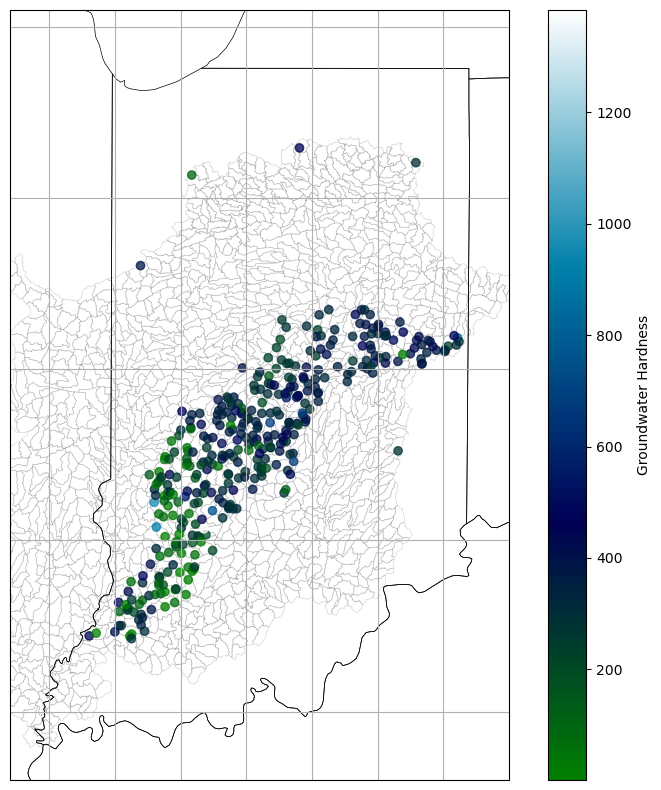

In [241]:
"""map groundwater hardness"""

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) 

# add HUC12 boundaries
HUC_gdf.plot(ax=ax, 
             #column = "geometry",
             facecolor="none", 
             edgecolor="black",
             alpha = 0.15,
             linewidth=0.5
             ) #facecolor colors interior of polygon!

# plot the IDNR data 
idnr_HUC.plot(ax = ax, 
                column = "HARDNESS", #if just this, generates points colored by variable
                alpha = 0.75, #transparancy
                cmap = "ocean",
                legend = True,
                legend_kwds=dict(label="Groundwater Hardness",pad=0.05), #additional: orientation="horizontal"
                ) 

# add state boundaries, gridlines
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
ax.gridlines()

# show map 
plt.show();

There might be some general trend that hardness decreases to the southwest. 

We'll want to get values for each of the HUC12 subbasins (those that are within the bounds of the data provided that is, i.e. within the points sampled) by interpolating values between points. This could be used to compare to other spatially distributed data that extends between the sample points. I completed this through a nearest-neighbor interpolation. 

## Nearest - Neighbor Interpolation of Groundwater

The following code would have changed the coordinate projection to 'NAD83' to preserve relative space between points in nearest neighbor interpolation.

In [242]:
"""convert lat lon to easting/northing to make interpolation accurate"""

# convert projection
#idnr_HUC = (gpd.GeoDataFrame(idnr_HUC, crs="EPSG:4326", geometry=gpd.points_from_xy(idnr_HUC["lon"], idnr_HUC["lat"]))
#            .to_crs("EPSG:3347")
#        )

# create new columns 
#idnr_HUC["Easting"], idnr_HUC["Northing"] = (idnr_HUC.geometry.x), (idnr_HUC.geometry.y)
#idnr_HUC.head()

'convert lat lon to easting/northing to make interpolation accurate'


I couldn't figure out how to change the projection once the interpolation had been created, so I'm sticking with lat lon. This is not great because longitude distance changes by distance from the poles, but hopefully with the method of interpolation and the small (can you consider state-size small?) area of study, results will be similar. 

C:\Users\janel\AppData\Local\Temp\ipykernel_17540\3249521457.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, "ok", color = "orange", alpha = 0.25, label="groundwater point")


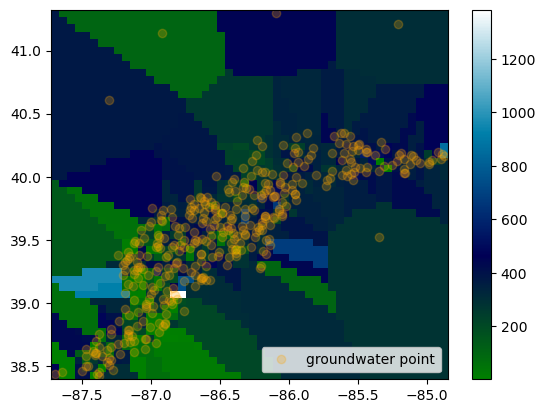

In [243]:
""" Spatial interpolation using nearest neighbors """

# set dimensions
x = idnr_HUC.lon
y = idnr_HUC.lat
z = idnr_HUC.HARDNESS

# create 2D grid for interpolation
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  

# interpolate variable
interp = NearestNDInterpolator(list(zip(x, y)), z)
Z = interp(X, Y)

# plot the interpolation
plt.pcolormesh(X, Y, Z, cmap = 'ocean', shading='auto')
plt.plot(x, y, "ok", color = "orange", alpha = 0.25, label="groundwater point")
plt.legend()
plt.colorbar()
plt.show()



The map looks a bit warped due to being fitted to a square with each extent to one of the groundwater points.

As expected, the nearest-neighbor grid shows a large portion of extrapolated data (such as that extending beyond any groundwater point). I would have been interested in clipping the interpolation to the outside edge of all points, not just the rectangular edge.  

I don't have the remaining time or ability to do further analysis with this result (I've been stuck on how to alter or add the geospatial reference), so I'll make it into an alright-looking figure.

C:\Users\janel\AppData\Local\Temp\ipykernel_17540\1787047429.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, "ok", color = "black", markersize = 1.5, alpha = 0.5, label="Groundwater sample points")


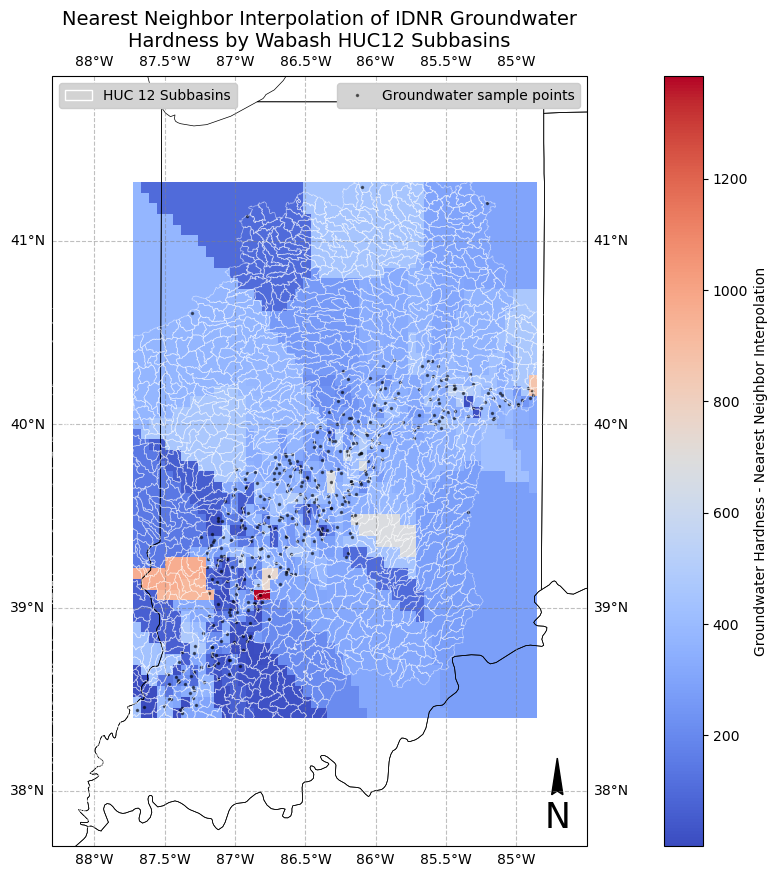

In [244]:
""" Plot with all data"""

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) 

# set colors to something bearable 
cmap = "coolwarm"


# ***********************
#  add all data types
# ***********************

# add nearest neighbor results
plt.pcolormesh(X, Y, Z, cmap = cmap, shading='auto') 

# plot HUC 12 boundaries
HUC_gdf.plot(ax=ax, 
             facecolor="none", 
             edgecolor="white",
             alpha = 0.5,
             linewidth=0.5,
             zorder = 10,
             ) #facecolor colors interior of polygon!

# plot points with cmap so colorbar shows later
idnr_HUC.plot(ax = ax, 
                column = "HARDNESS", #if just this, generates points colored by variable
                markersize = 0.1,
                #color="b",
                alpha = 1, #transparancy
                cmap = cmap,
                legend = True,
                legend_kwds=dict(label="Groundwater Hardness - Nearest Neighbor Interpolation",pad=0.1), #additional: orientation="horizontal"
                ) 

# add sample points
plt.plot(x, y, "ok", color = "black", markersize = 1.5, alpha = 0.5, label="Groundwater sample points")


# ***********************
#  meta map features
# ***********************

# add state boundaries
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)

# set extent
ax.set_extent([-88.3, -84.5, 37.7, 41.9], crs=cartopy.crs.PlateCarree())

# add gridlines
gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")

# set title
ax.set_title("Nearest Neighbor Interpolation of IDNR Groundwater\nHardness by Wabash HUC12 Subbasins", size = 14)

# plot north arrow
ax.text(x=-84.8, y=37.8, s='N', fontsize=25)
ax.arrow(-84.71, 38, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')


# add huc 12 boundaries to legend (this required a creative solution)
# make a dummy object that looks similar
import matplotlib.patches as mpatches
proxy_artist = mpatches.Rectangle((0, 0), 1, 0.1, 
                                  linewidth=1, 
                                  edgecolor='white', 
                                  facecolor='none', 
                                  label = "HUC 12 Subbasins")

# manually add the label
legend1 = ax.legend(handles=[proxy_artist], facecolor='lightgray', framealpha=1, loc='upper left', fancybox=True)
ax.add_artist(legend1)

# add the original legend
ax.legend(facecolor='lightgray', framealpha=1, loc='best', fancybox=True)


# show plot
plt.show();

>*Caption:* This plot shows a nearest-neighbor spatial interpolation of groundwater hardness using the IDNR historical groundwater chemistry dataset, restricted to points found both within the Wabash Basin and in Indiana. It features an overlay of HUC12 subbasins within the Wabash Basin.

### Groundwater recharge in carbon emission scenarios

Were the analysis to continue, I would use the data shown below: water recharge rates at HUC12 resolution from IUB's FutureWater website. I have imported the historical set below. 

In [245]:
#import data

#set the filepath
csvFWI_rech_hist = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\FWI_historical_recharge.csv"
csvFWI_rech_2050_45 = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\FWI_recharge_2050_RCP4.5.csv'

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
FWI_gw_full = pd.read_csv(csvFWI_rech_hist, 
                             header = 0, 
                             skiprows = 0,
                             )

# show the top of the dataset
FWI_gw_full.head()

,avg_mon_perc,subbasin,gcm_id,calendar_month
0,21.5931,1,11,1
1,25.1928,1,11,2
2,25.5927,1,11,3
3,20.0078,1,11,4
4,13.0589,1,11,5
